In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Transaction-level Dataset


In [2]:
## Load the data into a DataFrame
transactions=pd.read_csv('/Users/austinlasseter/DSI-EC-2/projects/datasets/iowa_liquor_short.csv')

In [3]:
# Drop the columns I don't plan to use
transactions=transactions.drop(['Area_name', 'State', 'Unnamed: 0', 'Date', 'County Number'], axis=1);

In [4]:
# Some of these names are really long.
transactions.columns

Index(['FIPS', 'Rural_urban_continuum_code_2013', 'Unemployment_rate_2016',
       'Median_Household_Income_2016', 'CENSUS_2010_POP', 'County',
       'Store Number', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Year'],
      dtype='object')

In [5]:
# Shorten those names, and make them lower-case (this is best practice)
new_cols=['fips', 'metro', 'unemployment',
       'income', 'population', 'county',
       'store', 'cost', 'retail',
       'bottles', 'year']
transactions.columns=new_cols
transactions.head()

,fips,metro,unemployment,income,population,county,store,cost,retail,bottles,year
0,19001,8.0,3.0,53416.0,7682,Adair,3461,$5.23,$7.85,12,2015
1,19001,8.0,3.0,53416.0,7682,Adair,3461,$6.74,$10.11,4,2015
2,19001,8.0,3.0,53416.0,7682,Adair,3461,$4.00,$6.00,3,2015
3,19001,8.0,3.0,53416.0,7682,Adair,4620,$5.48,$8.22,24,2015
4,19001,8.0,3.0,53416.0,7682,Adair,4654,$12.05,$18.08,12,2015


In [6]:
# Convert cost and retail into numeric values
transactions['cost']=transactions['cost'].replace( '[\$,)]','', regex=True ).astype(float)
transactions['retail']=transactions['retail'].replace( '[\$,)]','', regex=True ).astype(float)

In [7]:
# Make sure that "bottles" is an integer
transactions.bottles.dtype

dtype('int64')

In [8]:
# restrict the dataset only to 2015 sales (so we have a complete year of information)
transactions=transactions[transactions['year']==2015]

In [9]:
# Calculate transaction-level profit. Note that we include a multiplier of 18% for mark-up over state profit.
transactions['profit_per_sale'] = ((transactions['retail'] - transactions['cost'])*transactions['bottles'])*1.18
transactions.head()

,fips,metro,unemployment,income,population,county,store,cost,retail,bottles,year,profit_per_sale
0,19001,8.0,3.0,53416.0,7682,Adair,3461,5.23,7.85,12,2015,37.0992
1,19001,8.0,3.0,53416.0,7682,Adair,3461,6.74,10.11,4,2015,15.9064
2,19001,8.0,3.0,53416.0,7682,Adair,3461,4.00,6.00,3,2015,7.0800
3,19001,8.0,3.0,53416.0,7682,Adair,4620,5.48,8.22,24,2015,77.5968
4,19001,8.0,3.0,53416.0,7682,Adair,4654,12.05,18.08,12,2015,85.3848


In [10]:
# Calculate store-level annual profit
x=transactions['profit_per_sale'].groupby(transactions['store']).sum()
print(len(x))
profit=pd.DataFrame(x);

1375


In [11]:
# Reset the index so it isn't "store"
profit.reset_index(level=0, inplace=True)
profit.head()

,store,profit_per_sale
0,2106,564860.3596
1,2113,33857.9524
2,2130,436217.3732
3,2152,28489.2710
4,2178,110017.9018


# Store-level data

In [12]:
# How many stores are there the entire state? There are at least 3 ways to do this.
print(len(transactions.groupby('store')))
print(transactions.store.nunique())
print(len(transactions.store.unique()))

1375
1375
1375


In [13]:
# create a new dataset where every row is a store
stores=transactions.drop(['cost', 'year', 'profit_per_sale'], axis=1).groupby('store', as_index=False).mean()
print(len(stores))
stores.head()

1375


,store,fips,metro,unemployment,income,population,retail,bottles
0,2106,19013.0,3.0,4.7,50887.0,131090.0,16.225173,19.588247
1,2113,19187.0,5.0,4.0,48013.0,38013.0,15.963071,4.763409
2,2130,19013.0,3.0,4.7,50887.0,131090.0,15.423895,18.374778
3,2152,19033.0,5.0,3.7,53109.0,44151.0,12.897199,4.131010
4,2178,19005.0,6.0,5.0,49439.0,14330.0,15.046966,7.699587


In [14]:
# How many stores are there?
print(transactions.store.nunique())
print(stores.store.nunique())

1375
1375


In [15]:
# Merge back in the "annual profit" variable
stores=pd.merge(stores, profit, on='store')

In [16]:
# FIPS became a float. That decimal is annoying. Let's make it an integer again.
stores.fips=stores.fips.astype(int)

In [17]:
# Rename some of the columns
print(stores.columns)
new_cols=['store_id', 'fips', 'metro', 'unemployment', 'income', 'population',
       'ave_bottle_price', 'ave_number_bottles', 'annual_profit_per_store']
stores.columns=new_cols

Index(['store', 'fips', 'metro', 'unemployment', 'income', 'population',
       'retail', 'bottles', 'profit_per_sale'],
      dtype='object')


In [18]:
# Note the following:
    # ave_bottle_price = average cost of a bottle at that store (so it distinguishes cheap vs. fancy stores)
    # ave_number_bottles = average number of bottles per sale at that store (so it distinguishes hi vs low-selling stores)
stores.head()

,store_id,fips,metro,unemployment,income,population,ave_bottle_price,ave_number_bottles,annual_profit_per_store
0,2106,19013,3.0,4.7,50887.0,131090.0,16.225173,19.588247,564860.3596
1,2113,19187,5.0,4.0,48013.0,38013.0,15.963071,4.763409,33857.9524
2,2130,19013,3.0,4.7,50887.0,131090.0,15.423895,18.374778,436217.3732
3,2152,19033,5.0,3.7,53109.0,44151.0,12.897199,4.131010,28489.2710
4,2178,19005,6.0,5.0,49439.0,14330.0,15.046966,7.699587,110017.9018


1375


<function matplotlib.pyplot.show>

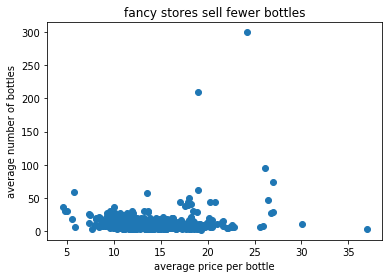

In [19]:
# I would guess that stores with high average bottle price have low average number, and vice versa. Let's see:
x=stores['ave_bottle_price']
y=stores['ave_number_bottles']
print(len(x))

plt.scatter(x,y)
plt.xlabel('average price per bottle')
plt.ylabel('average number of bottles')
plt.title('fancy stores sell fewer bottles')
plt.show

In [20]:
# How many counties are there?
stores.fips.nunique()

99

In [21]:
# How many stores are there in each county?
x=stores.fips.value_counts()
print(len(x))
x.head()

99


19153    206
19113    101
19013     72
19163     66
19103     53
Name: fips, dtype: int64

In [22]:
# Save that information into a county-level variable
x=stores.fips.value_counts()
print(len(x))
stores_in_fips=pd.DataFrame(x);

99


In [23]:
# Reset the index so it isn't "fips"
stores_in_fips.reset_index(level=0, inplace=True)

In [24]:
# rename the columns
new_cols=['fips', 'number_of_stores']
stores_in_fips.columns=new_cols
print(len(stores_in_fips))
stores_in_fips.head()

99


,fips,number_of_stores
0,19153,206
1,19113,101
2,19013,72
3,19163,66
4,19103,53


In [25]:
# Merge back in the "stores in fips" variable
stores=pd.merge(stores, stores_in_fips, on='fips')

In [26]:
print(len(stores.groupby('fips').number_of_stores.value_counts()))
stores.groupby('fips').number_of_stores.value_counts().head(10)

99


fips   number_of_stores
19001  8                    8
19003  1                    1
19005  6                    6
19007  6                    6
19009  3                    3
19011  6                    6
19013  72                  72
19015  15                  15
19017  9                    9
19019  10                  10
Name: number_of_stores, dtype: int64

In [27]:
# Stores by population
stores['density']=stores['population']/stores['number_of_stores']

In [28]:
stores.groupby('fips').density.mean().head()

fips
19001     960.250000
19003    4029.000000
19005    2388.333333
19007    2147.833333
19009    2039.666667
Name: density, dtype: float64

## County-level dataset

In [29]:
# create a new dataset where every row is a county
stores2=stores.drop(['ave_bottle_price', 'ave_number_bottles'], axis=1)
counties=stores2.groupby('fips', as_index=False).mean()
print(len(counties))
counties.head()

99


,fips,store_id,metro,unemployment,income,population,annual_profit_per_store,number_of_stores,density
0,19001,4405.375000,8.0,3.0,53416.0,7682.0,20967.800550,8.0,960.250000
1,19003,2327.000000,9.0,2.7,46939.0,4029.0,39665.440400,1.0,4029.000000
2,19005,4045.166667,6.0,5.0,49439.0,14330.0,54280.051133,6.0,2388.333333
3,19007,3928.500000,7.0,4.8,39124.0,12887.0,54955.548033,6.0,2147.833333
4,19009,4442.333333,8.0,3.3,49560.0,6119.0,22936.910800,3.0,2039.666667


In [30]:
# How many counties are there?
print(transactions.fips.nunique())
print(stores.fips.nunique())
print(counties.fips.nunique())

99
99
99


In [31]:
# Drop Store ID. We no longer need it.
counties=counties.drop('store_id', axis=1)

In [32]:
# take a look at the counties dataset:
print(counties.shape)
counties.head()

(99, 8)


,fips,metro,unemployment,income,population,annual_profit_per_store,number_of_stores,density
0,19001,8.0,3.0,53416.0,7682.0,20967.800550,8.0,960.250000
1,19003,9.0,2.7,46939.0,4029.0,39665.440400,1.0,4029.000000
2,19005,6.0,5.0,49439.0,14330.0,54280.051133,6.0,2388.333333
3,19007,7.0,4.8,39124.0,12887.0,54955.548033,6.0,2147.833333
4,19009,8.0,3.3,49560.0,6119.0,22936.910800,3.0,2039.666667


In [33]:
# Rename some of the columns
counties.columns
#new_cols=['store_id', 'fips', 'metro', 'unemployment', 'income', 'population',
#       'ave_bottle_price', 'ave_number_bottles', 'annual_profit_per_store']
#stores.columns=new_cols

Index(['fips', 'metro', 'unemployment', 'income', 'population',
       'annual_profit_per_store', 'number_of_stores', 'density'],
      dtype='object')

In [34]:
# Note the following:
    # ave_bottle_price = average cost of a bottle at that store (so it distinguishes cheap vs. fancy stores)
    # ave_number_bottles = average number of bottles per sale at that store (so it distinguishes hi vs low-selling stores)
counties.head()

,fips,metro,unemployment,income,population,annual_profit_per_store,number_of_stores,density
0,19001,8.0,3.0,53416.0,7682.0,20967.800550,8.0,960.250000
1,19003,9.0,2.7,46939.0,4029.0,39665.440400,1.0,4029.000000
2,19005,6.0,5.0,49439.0,14330.0,54280.051133,6.0,2388.333333
3,19007,7.0,4.8,39124.0,12887.0,54955.548033,6.0,2147.833333
4,19009,8.0,3.3,49560.0,6119.0,22936.910800,3.0,2039.666667


<function matplotlib.pyplot.show>

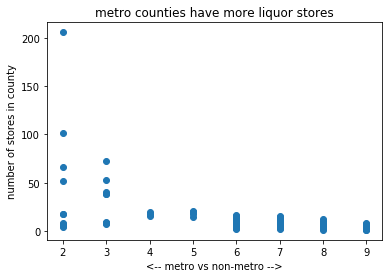

In [35]:
# Is there a relationship between nonmetro status and number of stores in a county?
x=counties['metro']
y=counties['number_of_stores']
plt.scatter(x,y)
plt.xlabel('<-- metro vs non-metro -->')
plt.ylabel('number of stores in county')
plt.title('metro counties have more liquor stores')
plt.show

In [36]:
# Polk county has over 200 liquor stores.
counties[counties['fips']==19153]

,fips,metro,unemployment,income,population,annual_profit_per_store,number_of_stores,density
76,19153,2.0,3.5,64169.0,430640.0,122002.249878,206.0,2090.485437


In [38]:
# What's the distribution of counties by "metro"?
counties.metro.value_counts()
# There are only 5 suburban counties.

6.0    26
7.0    24
2.0    12
9.0    11
3.0     9
8.0     9
5.0     5
4.0     3
Name: metro, dtype: int64

In [40]:
# What are their fips codes?
counties[counties.metro==5].fips

16    19033
28    19057
55    19111
89    19179
93    19187
Name: fips, dtype: int64

In [51]:
# What are their names?
for n in [19033, 19057, 19111, 19179, 19187]:
    print(n, transactions[transactions['fips']==n].county.max())

19033 Cerro Gordo
19057 Des Moines
19111 Lee
19179 Wapello
19187 Webster


## Save the datasets for use in the next jupyter notebook

In [37]:
# Save your work to a csv
stores.to_csv('/Users/austinlasseter/DSI-EC-2/projects/datasets/iowa_stores.csv')
counties.to_csv('/Users/austinlasseter/DSI-EC-2/projects/datasets/iowa_counties.csv')